# JAX의 세계속으로

## JAX란?

[JAX](https://github.com/google/jax)는 구글에서 새로 개발되고 있는 수치연산 및 머신러닝용 라이브러리입니다. 현재 구글 및 딥마인드에서 수행하는 많은 연구가 JAX를 기반으로 하고 있습니다.[1](https://github.com/n2cholas/awesome-jax) [2](https://www.deepmind.com/blog/using-jax-to-accelerate-our-research)
JAX는 [Tensorflow](https://www.tensorflow.org/)나 [PyTorch](https://pytorch.org/)와 같은 일반적인 딥러닝 라이브러리와는 다른 다음과 같은 특징을 가지고 있습니다. 

- JAX는 Tensorflow나 PyTorch와 다르게 Stateless합니다.
- JAX의 JIT(Just-In-Time compile)은 순수함수에 대해서만 제공됩니다.
- pmap 및 vmap을 통해서 병렬화하기에 용이합니다. 

JAX 자체는 Tensorflow나 PyTorch와는 다르게 그 자체로 딥러닝을 위해 제공되는 것이 아닙니다. 딥러닝을 조금 더 추상적인 수준에서 하고 싶다면 딥마인드의 [Haiku](https://github.com/deepmind/dm-haiku)나 구글의 [Flax](https://github.com/google/flax)를 참조하세요. 


## JAX의 특징들
### grad(미분연산 엔진)
jax,grad는 어떤 함수의 미분값을 반환하는 함수(도함수)로 만들어줍니다. 다음 코드를 실행해 봅시다. 

In [3]:
from jax import grad
from jax import numpy as np

def f(x):
    return x ** 2

df = grad(f)

x = float(input("임의의 수를 입력해보세요"))

print(f(x)) # 원함수
print(df(x)) # 도함수

임의의 수를 입력해보세요 13


169.0
26.0


In [5]:
from jax import grad
from jax import numpy as np

def f(x):
    return x ** 2

df = grad(f)

x = np.arange(0, 10, dtype=np.float32) 

print(np.array([f(n) for n in x])) # 원함수
print(np.array([df(n) for n in x])) # 도함수

[ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


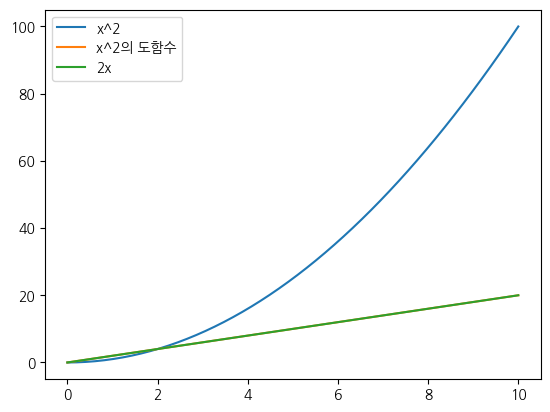

In [6]:
import matplotlib.pyplot as plt

# 한글 세팅
plt.rc('font', family='NanumGothic')


# 미리 정의된 x^의 도함수 -> 2x

def g(x):
    return 2 * x


x = np.linspace(start=0, stop=10)


plt.plot(x, np.array([f(n) for n in x]), label='x^2')
plt.plot(x, np.array([df(n) for n in x]), label='x^2의 도함수')
plt.plot(x, np.array([g(n) for n in x]), label='2x')
plt.legend()

### vmap(벡터화 함수)
위에서 미분값을 계산하기 위해서 람다 형식을 사용했지만, 실제 이렇게 사용하기에는 귀찮은 점이 많습니다. 그래서 벡터 형식으로 실행하려고 입력값을 ```np.arange(0, 10, dtype=np.float32)```로 설정하고 연산을 시도한다면 다음과 같은 에러와 마주하게 될 것입니다.

In [7]:
x = np.arange(0, 10, dtype=np.float32) 

print(f(x)) # 원함수
print(df(x)) # 벡터화되지 않은 도함수

[ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]


TypeError: Gradient only defined for scalar-output functions. Output had shape: (10,).

```jax.grad``` 함수는 스칼라 출력에 대해서만 연산을 지원합니다. 이 이유가 바로 왜 ```jax.vmap```을 써야하는 지 보여줍니다. 한 번 적용해보겠습니다. 

In [8]:
from jax import vmap # for calculating in vectorised form

df_vect = vmap(df)
x = np.arange(0, 10, dtype=np.float32) 

print(f(x)) # 원함수
print(df_vect(x)) # 벡터화된 도함수

[ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


연산이 잘되네요! vmap은 단순히 grad 함수의 연산을 벡터화할 뿐만 아니라 행렬연산과 같은 함수들의 벡터화를 하는 것에도 사용됩니다. 

### JIT(Just-In-Time 컴파일)

Just In Time 컴파일(실행시 컴파일)은 연산속도의 상당한 향상을 만들 수 있습니다. 한 번 확인해보죠!

In [10]:
from jax import jit

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid_jit = jit(sigmoid)

x = np.linspace(-1, 1, 1000000, dtype=np.float32)

%timeit -r 10 sigmoid(x)
%timeit -r 10 sigmoid_jit(x)

1.54 ms ± 23.1 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)
221 µs ± 12.5 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


거의 6~7배의 성능향상을 보여주네요. (실행환경마다 속도는 상이할 수 있습니다.) 하지만 이렇게 jitting(실행시 컴파일) 하는 것은 순수형 함수에 대해서만 적용됩니다. 아닌 예시를 한 번 살펴보죠. 

In [11]:
from jax import jit

y = 0

@jit
def jit_test_func(x): # 실행시 컴파일이 적용된 함수
    return x+y

def nonjit_test_func(x): # 실행시 컴파일이 적용되지 않은 함수
    return x+y

for i in range(3):
    print(f"실행시 컴파일이 적용된 함수의 출력값: {jit_test_func(i)}")
    print(f"실행시 컴파일이 적용되지 않은 함수의 출력값: {nonjit_test_func(i)}")
    y += 1

실행시 컴파일이 적용된 함수의 출력값: 0
실행시 컴파일이 적용되지 않은 함수의 출력값: 0
실행시 컴파일이 적용된 함수의 출력값: 1
실행시 컴파일이 적용되지 않은 함수의 출력값: 2
실행시 컴파일이 적용된 함수의 출력값: 2
실행시 컴파일이 적용되지 않은 함수의 출력값: 4


보시다시피 전역변수 y의 값이 반영되지 않는다는 것을 확인할 수 있습니다. y를 적용하고 싶은 경우 함수의 입력으로서 y를 추가해야 합니다. 추가한 예시를 보겠습니다. 

In [12]:
from jax import jit

y = 0

@jit
def correctly_jitted_test_func(x, y): # 실행시 컴파일이 적용되었으며, 연산에 사용되는 모든 입력을 함수의 입력으로 받는 함수
    return x+y

def nonjit_test_func(x): # 실행시 컴파일이 적용되지 않은 함수
    return x+y

for i in range(3):
    print(f"실행시 컴파일이 적용되었으며, 연산에 사용되는 모든 입력을 함수의 입력으로 받는 함수의 출력값: {correctly_jitted_test_func(i, y)}")
    print(f"실행시 컴파일이 적용되지 않는 함수의 출력값: {nonjit_test_func(i)}")
    y += 1
    

실행시 컴파일이 적용되었으며, 연산에 사용되는 모든 입력을 함수의 입력으로 받는 함수의 출력값: 0
실행시 컴파일이 적용되지 않는 함수의 출력값: 0
실행시 컴파일이 적용되었으며, 연산에 사용되는 모든 입력을 함수의 입력으로 받는 함수의 출력값: 2
실행시 컴파일이 적용되지 않는 함수의 출력값: 2
실행시 컴파일이 적용되었으며, 연산에 사용되는 모든 입력을 함수의 입력으로 받는 함수의 출력값: 4
실행시 컴파일이 적용되지 않는 함수의 출력값: 4


잘 되네요!

### PRNG(Pseudo Random Number Generation; 의사난수 생성)

JAX에서 꽤나 중요하게 기억해야 할 것은 JAX의 랜덤 패키지가 Numpy나 PyTorch와 같은 일반적인 라이브러리와 다르게 시드값이 필요함을 강제하고 있다는 것입니다. 불편하게 여겨질 수도 있지만, 이는 다른 사람들로 하여금 더 쉽게 결과를 재현할 수 있도록 도와줍니다. 키를 어떻게 사용하는 지 보겠습니다.  

In [13]:
# 이 코드는 https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html에서 비롯되었습니다. 

from jax import random

key = random.PRNGKey(42)

print(key)

print(random.normal(key))
print(random.normal(key))

[ 0 42]
-0.18471177
-0.18471177


랜덤으로 어떤 수를 생성하는 과정은 시드를 선택하는 것에서 시작합니다. 시드의 값을 다른 랜덤 라이브러리를 사용해 다른 값을 뽑는 것도 가능하지만, JAX는 내부적으로 'subkey'를 뽑아 다른 수를 뽑을 수 있게끔 합니다. 어떻게 사용하는 지 보겠습니다.

In [14]:
# 이 코드는 https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html에서 비롯되었습니다. 

from jax import random

key = random.PRNGKey(42)

print(f"원본 키: {key}")

print(f"정규분포에서 원본 키를 바탕으로 추출된 값: {random.normal(key)}")

newkey, subkey = random.split(key)

print(f"원본키로 부터 추출된 서브 키: {subkey}")

print(f"정규분포에서 서브 키를 바탕으로 추출된 값: {random.normal(subkey)}")

원본 키: [ 0 42]
정규분포에서 원본 키를 바탕으로 추출된 값: -0.1847117692232132
원본키로 부터 추출된 서브 키: [255383827 267815257]
정규분포에서 서브 키를 바탕으로 추출된 값: 1.369469404220581


결과를 재현하고 싶다면 같은 키를, 다른 값으로 샘플링하고 싶다면 다른 키를 사용하세요. 

첫 번째 챕터가 끝났습니다. 두 번째 챕터에서는 다양한 형태의 회귀를 다룰 예정입니다. 읽어주셔서 감사합니다!

### 참조
- JAX 도큐멘테이션(https://jax.readthedocs.io/en/latest/index.html)

### 저작권

Copyright 2023, 김동영

이 문서에 기하여, 이 소프트웨어와, 이와 연관된 모든 문서(이하 ‘소프트웨어’라 한다)의 복제본을 보유하게 되는 모든 사용자에 대하여, 다음의 권한이 무상으로 부여된다. 소프트웨어의 사용, 복제, 변경, 통합, 발행, 배포, 재실시, 판매에 대한 제약을 포함한 어떠한 제약 없이 본 소프트웨어를 취급할 수 있으며, 이는 제3자에 대한 소프트웨어 지급시에도 동일하게 적용된다. 단, 이 모든 사항은 아래의 조건하에 적용된다.

위 저작권 표시와 본 허가조항은 소프트웨어의 모든 복제본 혹은 중요한 부분에 포함되어야 한다.

소프트웨어는 "있는 그대로" 제공된다. 판매적격성, 특정 용도에 대한 적합성, 준법성, 혹은 그 이상의 범위를 포함한 사항에 있어서, 명시적 혹은 묵시적인 어떠한 보증도 하지 않는다. 계약, 불법행위등의 과정상의 개입여부에 상관없이 어떠한 상황에서도, 본 소프트웨어의 저작자 혹은 저작권자는, 소프트웨어에서 혹은 소프트웨어와 연관되어 발생하는, 또한 사용과정중 혹은 기타 거래도중 발생하는 어떠한 소유권 청구, 피해, 혹은 기타 다른 법적 책임에 대해서도 책임을 지지 않는다.